In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


# Setup

## Domain

In [2]:
from jwave.geometry import Domain

N, dx = (128, 128), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)

## Acoustic medium

In [3]:
from jwave.geometry import Medium

medium = Medium(domain=domain, sound_speed=1500.0)
print(medium)

Medium[jaxdf.discretization.FourierSeries](
  domain=Domain(N=(128, 128), dx=(0.0001, 0.0001)),
  sound_speed=1500.0,
  density=1.0,
  attenuation=1.0,
  pml_size=20.0
)


## Time

In [4]:
from jwave.geometry import TimeAxis

time_axis = TimeAxis.from_medium(medium, cfl=0.3)

2024-08-09 15:45:20.960231: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
time_axis

## Initial pressure

In [6]:
from jax import numpy as jnp

from jwave import FourierSeries
from jwave.geometry import circ_mask

p0 = 1.0 * jnp.expand_dims(circ_mask(N, 4, (80, 60)), -1)
p0 = FourierSeries(p0, domain)

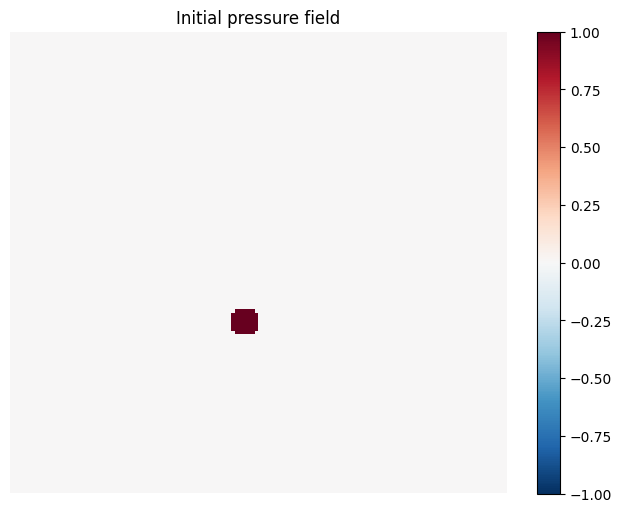

In [7]:
from matplotlib import pyplot as plt

from jwave.utils import show_field

show_field(p0)
plt.title(f"Initial pressure field")
plt.show()

# Run simulation

In [8]:
from jax import jit

from jwave.acoustics import simulate_wave_propagation


@jit
def compiled_simulator(medium, p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0)

In [9]:
pressure = compiled_simulator(medium, p0)

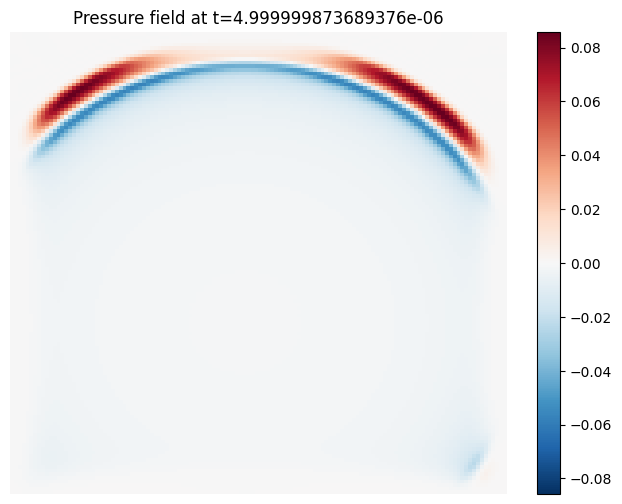

In [10]:
t = 250
show_field(pressure[t])
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")
plt.show()

# Timings

In [11]:
%timeit compiled_simulator(medium, p0).params.block_until_ready()

39.6 ms ± 187 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
